In [1]:
'''
Data is from https://github.com/mtoto/mtoto.github.io/tree/master/data/, from a 2017 spotify analysis project. My personal 
data would take five more days to be requested. For the purpose of this sprint, we will be using here jsons until the login 
API is fully functional.
''

'\nData is from https://github.com/mtoto/mtoto.github.io/tree/master/data/, from a 2017 spotify analysis project. My personal \ndata would take thirty days to be requested. For the purpose of this sprint \n'

In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.dates as mdates
# To load the json as a pandas dataframe, if i use pd.read_json it will look off.

#These files were found on github and are not an accurate representation of our actual data. We will be replacing this with
#user data from login once that works.
with open("data/spotify_artist_2017-06-30.json", "r") as file:
    #had to do it line by line. I don't know why it was different.
    df_arts = pd.read_json(file)

with open("data/spotify_tracks_2017-06-30.json", "r") as file:
    df_tracks = pd.read_json(file)

C:\Users\kenne\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


With the code seperated from Json Files as tracks and artists, (i'm not sure this is how spofity gives it out)
We can start working with basic visualizations.

In [3]:
df_tracks_unnested = df_tracks.explode('artist_name').explode('artist_id')

# Converting timestamp to datetime
df_tracks_unnested['played_at'] = pd.to_datetime(df_tracks_unnested['played_at'], format='%Y-%m-%dT%H:%M:%S', errors='coerce')

# Merging
merged = pd.merge(df_tracks_unnested, df_arts, on='artist_id', how='left')

# Combine 'artist_name_x' and 'artist_name_y' into a single 'artist_name' column
merged['artist_name'] = merged['artist_name_x'].combine_first(merged['artist_name_y'])

# Drop unnecessary columns
merged = merged.drop(['artist_name_x', 'artist_name_y', 'artist_id'], axis=1)
#Excel can't handle datetimes with timezones. 
merged['played_at'] = merged['played_at'].dt.tz_localize(None)

In [4]:
merged.describe()

,disc_number,duration_ms,track_number,artist_followers,artist_popularity
count,6310.000000,6.310000e+03,6310.000000,6.309000e+03,6309.000000
mean,1.021870,2.856314e+05,5.301585,3.381881e+05,46.440323
std,0.187999,1.248190e+05,5.189591,1.271200e+06,20.223148
min,1.000000,3.653300e+04,1.000000,0.000000e+00,0.000000
25%,1.000000,2.123120e+05,2.000000,1.613000e+03,33.000000
50%,1.000000,2.550400e+05,4.000000,1.171100e+04,45.000000
75%,1.000000,3.399900e+05,7.000000,8.102700e+04,60.000000
max,9.000000,4.573933e+06,90.000000,1.098484e+07,100.000000


When the data is cleaned, we can effectively choose whatever we want for graphs in analysis. In the actual product, we hope to be significantly more detailed and use the API calls to actually use visuals for the artists and track ID, however, for our first product it simply has not been done yet

In [6]:
# Group by 'track_name' and keep only the times played.
cleaned_df = merged.groupby('track_name').agg(
    artist_name=('artist_name', 'first'),
    plays=('played_at', 'nunique')         
).reset_index()
cleaned_df



,track_name,artist_name,plays
0,#!*@ Me - Interlude,The Notorious B.I.G.,1
1,'Til Dawn,Nu:Tone,5
2,(Everybody Wanna Get Rich) Rite Away,Dr. John,2
3,(Fallin' Like) Dominoes,Donald Byrd,2
4,(I've Got a Gal In) Kalamazoo - Remastered,Glenn Miller,1
...,...,...,...
2431,Zone Out,David Mclorren,1
2432,fabric,Rude Kid,2
2433,lovers’ carvings,Bibio,1
2434,Úgy Akarok Élni,DSP,1


In [7]:
merged.columns.values.tolist()

['played_at',
 'artist_urls',
 'artist_href',
 'track_name',
 'preview_url',
 'explicit',
 'uri',
 'track_id',
 'playlist_url',
 'disc_number',
 'href',
 'duration_ms',
 'track_number',
 'type',
 'playlist_href',
 'spotify_external_url',
 'artist_followers',
 'artist_genres',
 'artist_popularity',
 'artist_name']

In [8]:
# Group by 'track_name' and calculate the total time listening for each track
artists = merged.groupby('track_name').agg(
    artist_name=('artist_name', 'first'),
    plays=('played_at', 'nunique'),
    song_length_ms=('duration_ms', 'first')  # Assuming you want the first played time for each track
).reset_index()

# Convert duration_ms to seconds
artists['duration_hours'] = artists['song_length_ms'] / (1000 * 60 * 60)

# Calculate total time listening by multiplying plays with duration in seconds
artists['total_time_listening'] = artists['plays'] * artists['duration_hours']

In [9]:
artist_stats = artists.groupby('artist_name').agg(
    total_listening_time=('total_time_listening', 'sum')
).reset_index()

# Sort by total listening time in descending order to find the most played artists
most_played_artists = artist_stats.sort_values(by='total_listening_time', ascending=False).head(25)

# Display the resulting DataFrame with the top fifteen most played artists
most_played_artists

,artist_name,total_listening_time
116,Banco De Gaia,6.092783
658,Junior Kimbrough,5.363315
1133,Sonic Species,3.630876
370,E-Clip,3.583914
16,Abakus,3.413484
45,Ali Farka Touré,3.066807
269,Count Basie,2.972668
19,Ace Ventura,2.687351
429,Fatboy Slim,2.216242
695,Killerwatts,2.140404


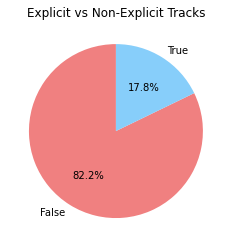

In [5]:
#Explicit vs nonExplicit songs.
explicit_counts = merged['explicit'].value_counts()
plt.pie(explicit_counts, labels=explicit_counts.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'lightskyblue'])
plt.title('Explicit vs Non-Explicit Tracks')
plt.show()

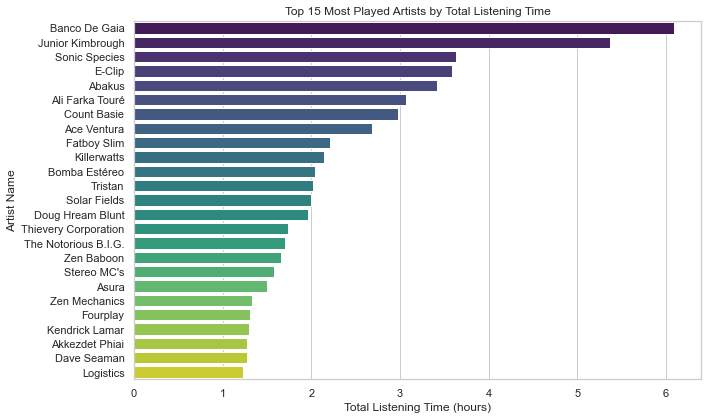

In [10]:
sns.set(style='whitegrid')

# Create a horizontal bar chart with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='total_listening_time', y='artist_name', data=most_played_artists, palette='viridis')

# Set labels and title
plt.xlabel('Total Listening Time (hours)')
plt.ylabel('Artist Name')
plt.title('Top 25 Most Played Artists by Total Listening Time')

# Show the plot
plt.tight_layout()
plt.show()

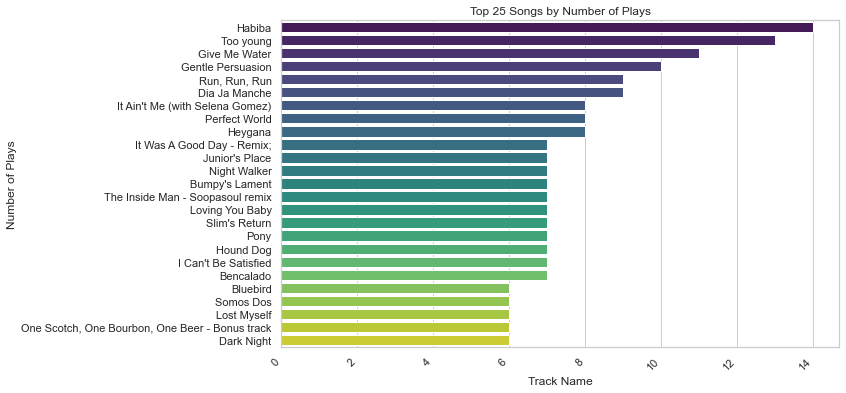

In [11]:

#barchart for most played songs.
top25 = cleaned_df.sort_values(by='plays', ascending=False).head(25)
plt.figure(figsize=(10, 6))
bar_chart = sns.barplot(x='plays', y='track_name', data=top25, palette='viridis', orient='h')

# Set labels and title
plt.xlabel('Track Name')
plt.ylabel('Number of Plays')
plt.title('Top 25 Songs by Number of Plays')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

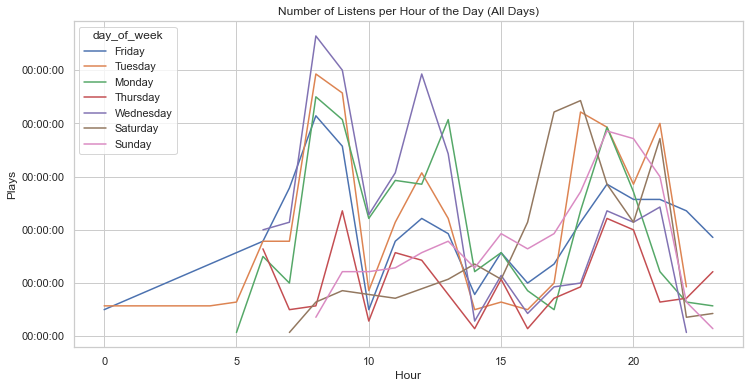

In [12]:
#Total Plays by day
merged_copy = merged.copy()

# Extract hour of the day and day of the week information
merged_copy['time_of_day'] = merged_copy['played_at'].dt.hour
merged_copy['day_of_week'] = merged_copy['played_at'].dt.day_name()

# Group by 'time_of_day' and 'day_of_week'
grouped_df = merged_copy.groupby(['time_of_day', 'day_of_week']).agg(plays=('played_at', 'nunique')).reset_index()

# Adjust plays for all days
grouped_df['plays'] = grouped_df['plays'] / 7

# Create a line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=grouped_df, x='time_of_day', y='plays', hue='day_of_week', markers=True, dashes=False)

# Set labels and title
plt.title("Number of Listens per Hour of the Day (All Days)")
plt.xlabel("Hour")
plt.ylabel("Plays")

# Format y-axis ticks as datetime
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

# Show the plot
plt.show()
